<h2><b>Importing libraries</b></h2>

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import time
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<h2><b>Getting data</b></h2>

In [2]:
histVale = web.DataReader('VALE', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histAzul = web.DataReader('AZUL4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histPetro = web.DataReader('PBR', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histItau = web.DataReader('ITUB', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histRio = web.DataReader('PRIO3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [3]:
historicStock = [histVale, histAzul, histBB, histPetro, histItau, histRio]

In [4]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [5]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [6]:
calculate_daily_inflation(monthlyInflation2018)

In [7]:
historicStock[4]

,High,Low,Open,Close,Volume,Adj Close,Month,DailyInflation,InflationHigh,InflationLow,InflationOpen,InflationClose
Date,,,,,,,,,,,,
2018-01-02,9.020000,8.846667,8.873333,9.020000,9065100.0,7.417422,1,1.000270,9.02,8.84,8.87,9.02
2018-01-03,9.153333,8.980000,9.006667,9.140000,26839200.0,7.516098,1,1.000541,9.15,8.98,9.00,9.14
2018-01-04,9.353333,9.226667,9.260000,9.253333,29857200.0,7.609297,1,1.000812,9.35,9.22,9.25,9.25
2018-01-05,9.380000,9.186667,9.220000,9.366667,10938600.0,7.702496,1,1.001082,9.37,9.18,9.21,9.36
2018-01-08,9.360000,9.233333,9.306667,9.240000,16406850.0,7.598333,1,1.001353,9.35,9.22,9.29,9.23
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,9.020000,8.730000,8.970000,8.760000,16073200.0,7.679347,12,1.073060,8.41,8.14,8.36,8.16
2018-12-24,8.790000,8.600000,8.690000,8.630000,6001200.0,7.565382,12,1.073449,8.19,8.01,8.10,8.04
2018-12-26,8.640000,8.430000,8.590000,8.640000,27750300.0,7.574151,12,1.073837,8.05,7.85,8.00,8.05


<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [8]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [9]:
calculate_lines()

In [10]:
def calculate_bollinger_bands():
    for stock in historicStock:
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
        
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]
        
        plt.plot(stock["LowerBollinger"], label="Lower")
        plt.plot(stock["UpperBollinger"], label="Upper")
        plt.plot(stock["Close"], label="Close")
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Preço')
        plt.title("Bandas de Bollinger")
        plt.show()

In [11]:
def calculate_bollinger_bands_stock(stock, inflation=False):
    if(inflation == False):
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
    else:
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]

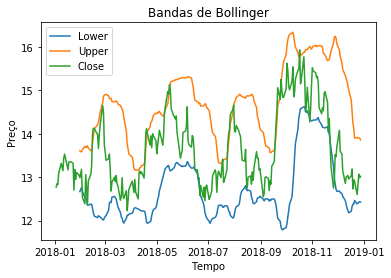

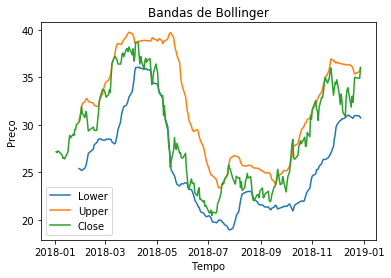

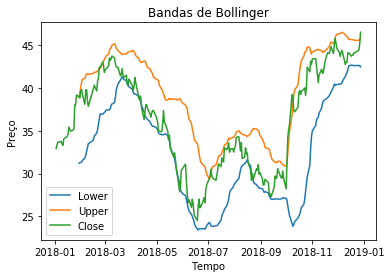

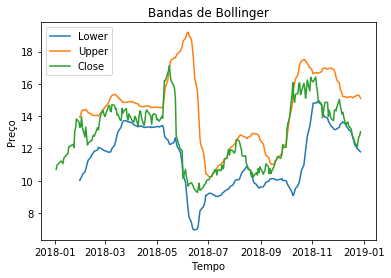

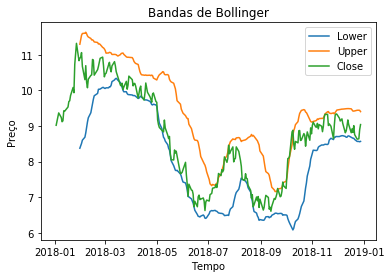

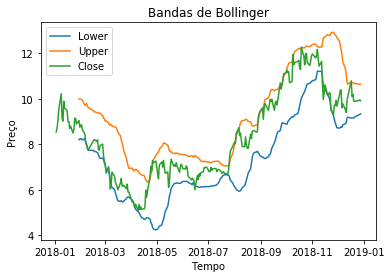

In [12]:
calculate_bollinger_bands()

In [13]:
def upOrDown():
    for stock in historicStock:
        stock["UpDown"] = stock["Close"].diff();
        stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [14]:
def upOrDownNpArray(array):
    difference = np.diff(array)
    diffReturn = []
    for i in difference:
        if i >= 0:
            diffReturn.append(1)
        else:
            diffReturn.append(0)
    return np.array(diffReturn)

In [15]:
def upOrDownStock(stock):
    stock["UpDown"] = stock["Close"].diff();
    stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [16]:
upOrDown()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [17]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [18]:
def calculate_RSI_stock(window, stock, inflation=False):
    if inflation == False:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
    else:
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [19]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [20]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

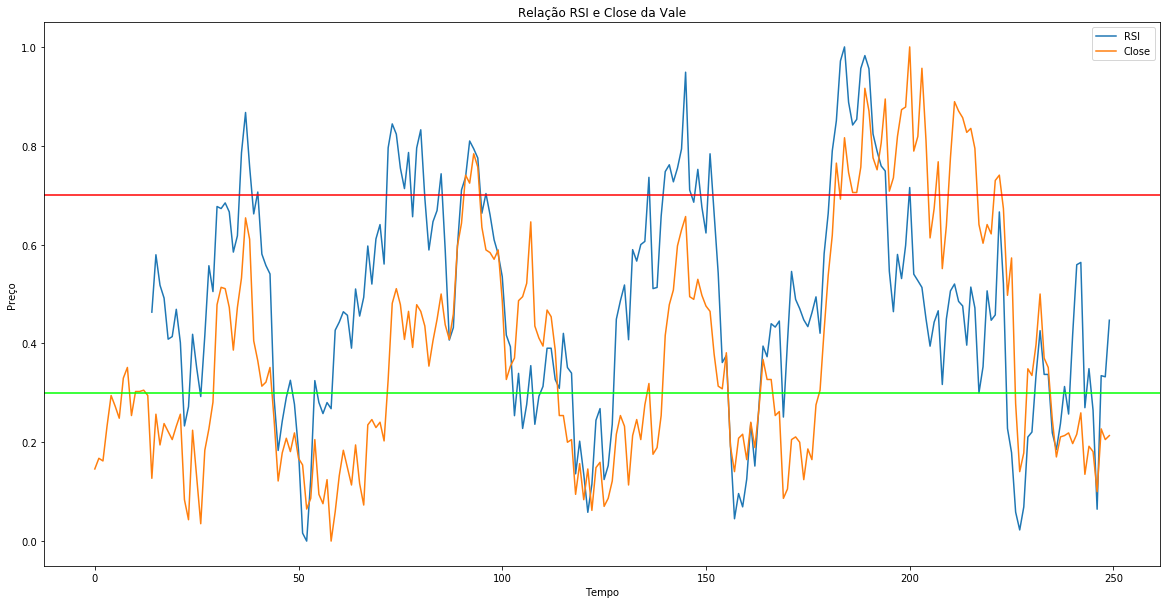

In [21]:
plot_rsi_close(historicStock[0], 'Vale')

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [22]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [23]:
def calculate_MFI_stock(window, stock, inflation=False):
    if inflation == False:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))
    else:
        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [24]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [25]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [26]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [27]:
def calculate_stochastic_oscillator_stock(window, stock, inflation=False):
    if inflation == False:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
    else:  
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [28]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [29]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

<h2><b>Function to plot correlation matrix</b></h2>

In [30]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]].corr()


    plt.figure(figsize = (10,10))
    sns.heatmap(corrMatrix, cmap='RdYlGn', center=0, annot=True)
    plt.show()

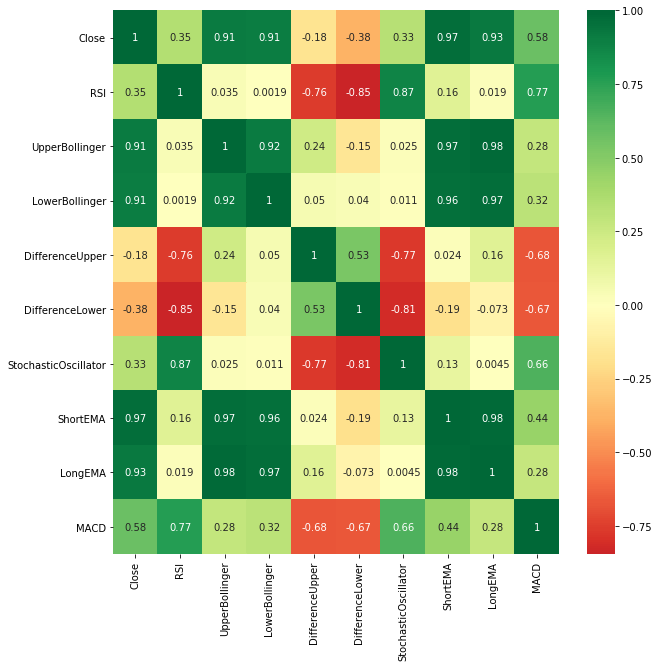

In [31]:
show_corr_matrix(historicStock[5])

<h2><b>Function to predict traditional SVM</b></h2>

In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
svmRegressorClose = svm.SVR(kernel="rbf")
svmRegressorNu = svm.NuSVR(kernel="rbf")

In [34]:
def predict_svm_traditional(stock, inflation=False, feature='close'):
    if feature == 'close':
        if inflation == False:
            stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
        
        parameters = {'C': [1, 10, 100], 'kernel': ('linear', 'rbf')}
        
        gssvm = GridSearchCV(svmRegressorClose, parameters)

        gssvm.fit(X_train, y_train)
        print(gssvm)


        y_pred = gssvm.predict(X_test)

#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train

In [35]:
def predict_plot_svm(stock, inflation=False, feature='close'):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.figure(figsize = (14,10))
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [36]:
def predict_plot_svm_all_stocks(stocks, inflation=False, feature='close'):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))

        plt.figure(figsize = (14,10))
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando SVM", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
[1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0
 1 0 0 1 0 1 0 1 1 1 1]
[1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0
 0 0 0 1 1 1 0 1 1 0 1]


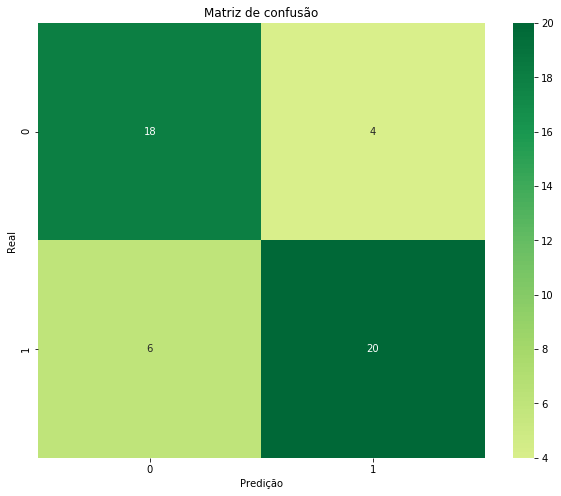

F1 score:  0.8
Precision score:  0.8333333333333334
Accuracy score:  0.7916666666666666
MAE score:  0.6093650048354878
MSE value:  0.43889398694540227
RMSE value:  0.6624907447998064


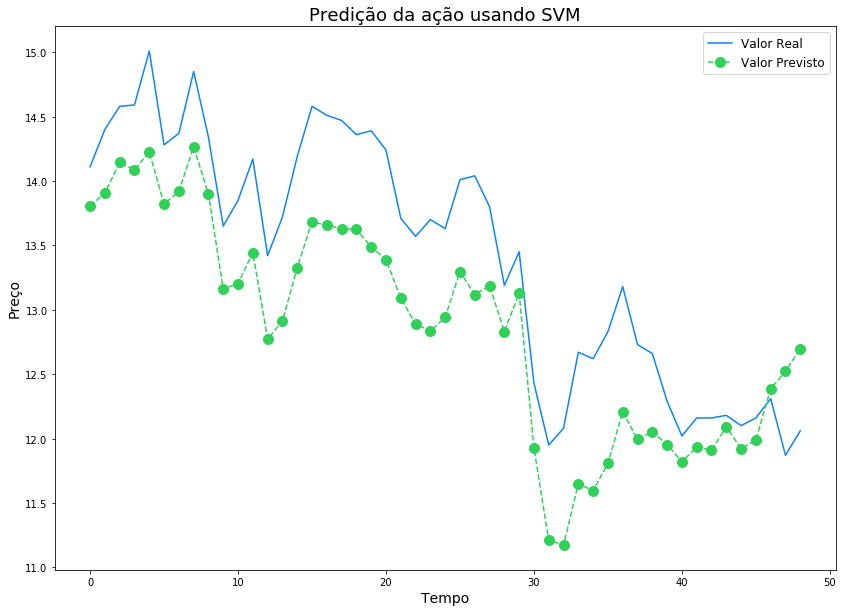

In [37]:
predict_plot_svm(historicStock[0], True)

<h2><b>Function to predict Nu SVM</b></h2>

In [38]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
    parameters = {'C': [1, 10, 100], 'kernel': ('linear', 'rbf'), 'degree':[1,2,3,4]}
    
    gssvm = GridSearchCV(svmRegressorClose, parameters)
    gssvm.fit(X_train, y_train)
    print(gssvm)
    
    y_pred = gssvm.predict(X_test)

#     print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [39]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Nu SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [40]:
def predict_plot_svm_nu_all_stocks(stocks, inflation=False):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_nu(stock)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))

        plt.figure(figsize = (14,10))
        sns.set_style("whitegrid")
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando Nu SVM", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'degree': [1, 2, 3, 4],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
[1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1
 0 0 0 1 1 1 0 0 0 1]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1]


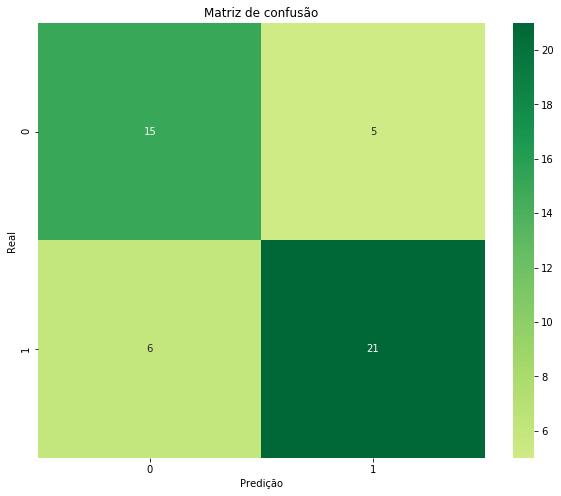

F1 score:  0.7924528301886792
Precision score:  0.8076923076923077
Accuracy score:  0.7659574468085106
MAE score:  0.6761231875933867
MSE value:  0.6723383436134149
RMSE value:  0.8199624037804507


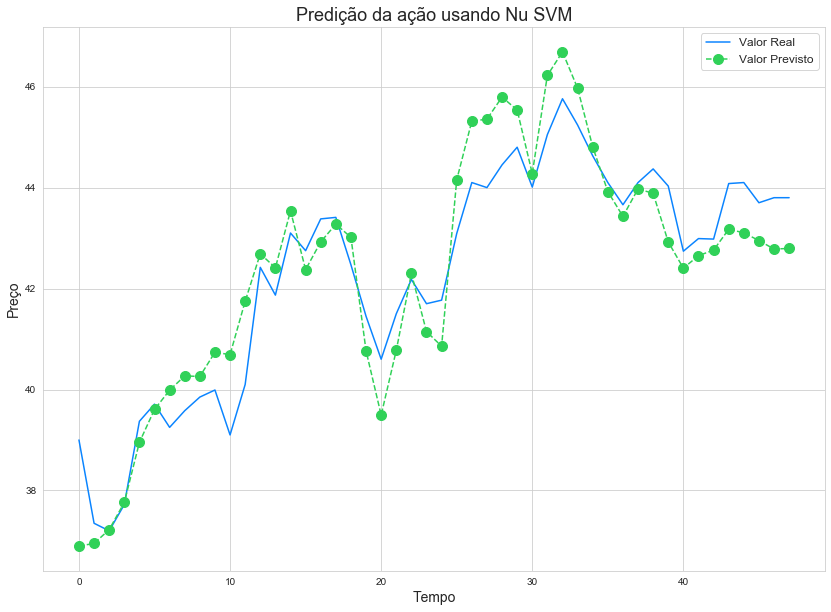

In [41]:
predict_plot_svm_nu(historicStock[2])

<h2><b>Scaling data for LSTM</b></h2>

In [42]:
# scaler = MinMaxScaler()
# stockScaled = []
# stocksScaled = []

# for stock in historicStock:
#     stocksScaled.append(stock)
    
# for stock in stocksScaled:
#     stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [43]:
# def predict_LSTM(stock, inflation=False):
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
#         stockY = stock["Close"][30:]
#     else:
#         stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
#         stockY = stock["InflationClose"][15:]
#     X = np.array(stockX)
#     y = np.array(stockY)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
#     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#     y_train = y_train.reshape(y_train.shape[0], 1, 1)
#     y_test = y_test.reshape(y_test.shape[0], 1, 1)
    
#     model = Sequential()

#     model.add(LSTM(128, activation='sigmoid', input_shape=(8,1)))
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(128, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(32, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(10, activation='softmax'))
#     model.add(Dropout(0.2))
    
#     model.compile(optimizer=Adam(lr=1e-3, decay=1e-5), metrics=['accuracy'])
    
#     model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [44]:
# predict_LSTM(stockScaled[0])

In [45]:
clf = KernelRidge(alpha=1.0)

In [46]:
def predict_kernel_ridge(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    clf = KernelRidge(alpha=1.0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Kernel Ridge", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [67]:
def predict_kernel_ridge_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        clf = KernelRidge(alpha=1.0)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))

        plt.figure(figsize = (14,10))
        sns.set_style("whitegrid")
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando Regressão Kernel Ridge", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

In [ ]:
predict_kernel_ridge_all_stocks(historicStock)

[1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0
 0 1 0 1 1 0 0 0 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0]


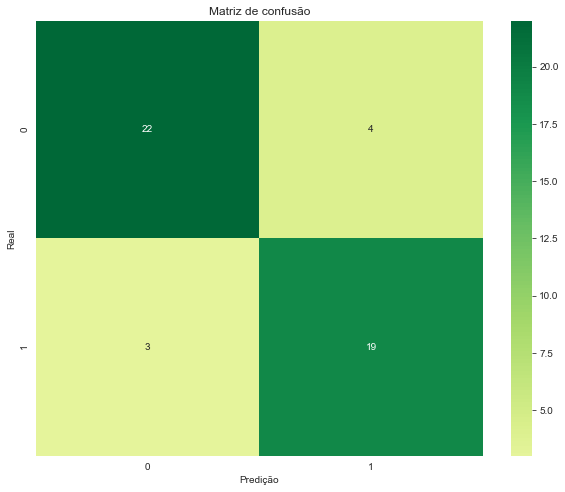

F1 score:  0.8444444444444444
Precision score:  0.8260869565217391
Accuracy score:  0.8541666666666666
MAE score:  0.930763315213565
MSE value:  2.179449613457809
RMSE value:  1.4762959098560862


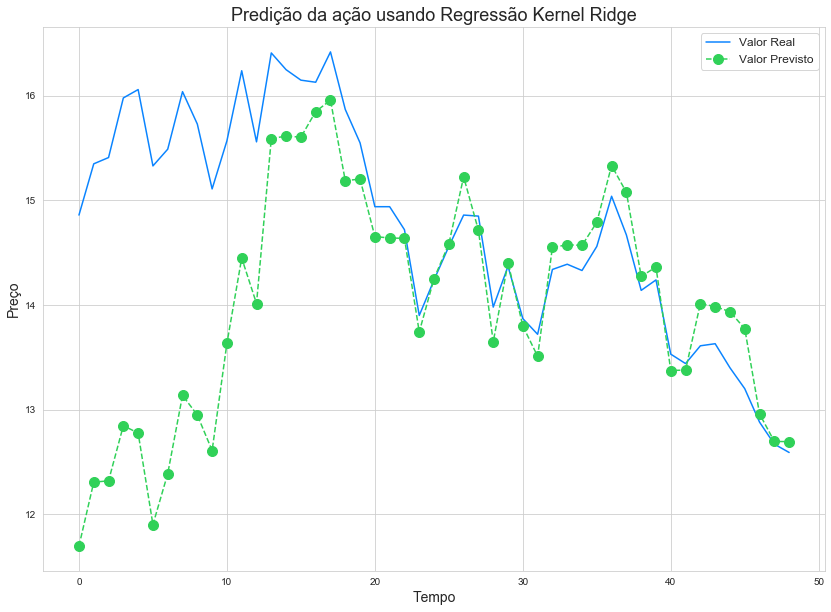

In [49]:
predict_kernel_ridge(historicStock[3])

In [50]:
regr = linear_model.LinearRegression()

In [51]:
def predict_linear(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
#     print('Coefficients: \n', regr.coef_)
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Linear", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [63]:
def predict_linear_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)

        y_pred = y_pred[5:]
        y_test = y_test[:-5]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (10,8))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title('Matriz de confusão')
        plt.show()

    #     print('Coefficients: \n', regr.coef_)

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        plt.figure(figsize = (14,10))
        sns.set_style("whitegrid")
        sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
        plt.title("Predição da ação usando Regressão Linear", fontsize=18)
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

[1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0
 1 0 0 1 0 1 0 1 1 1 1]
[1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0
 0 0 0 1 1 1 0 1 1 0 1]


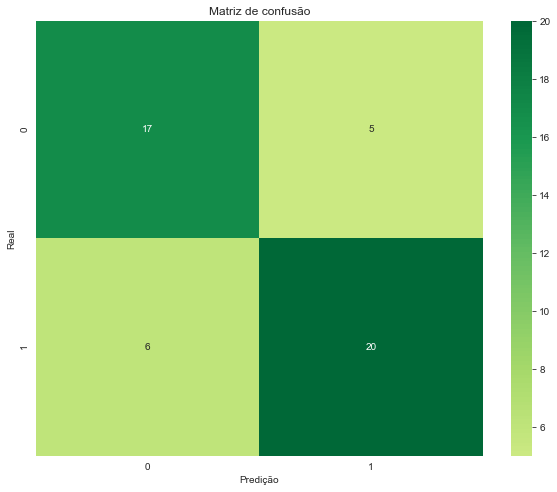

F1 score:  0.7843137254901961
Precision score:  0.8
Accuracy score:  0.7708333333333334
MAE score:  0.7480757128773907
MSE value:  0.6612123369707182
RMSE value:  0.8131496399622385
MAPE value:  5.267810529172415


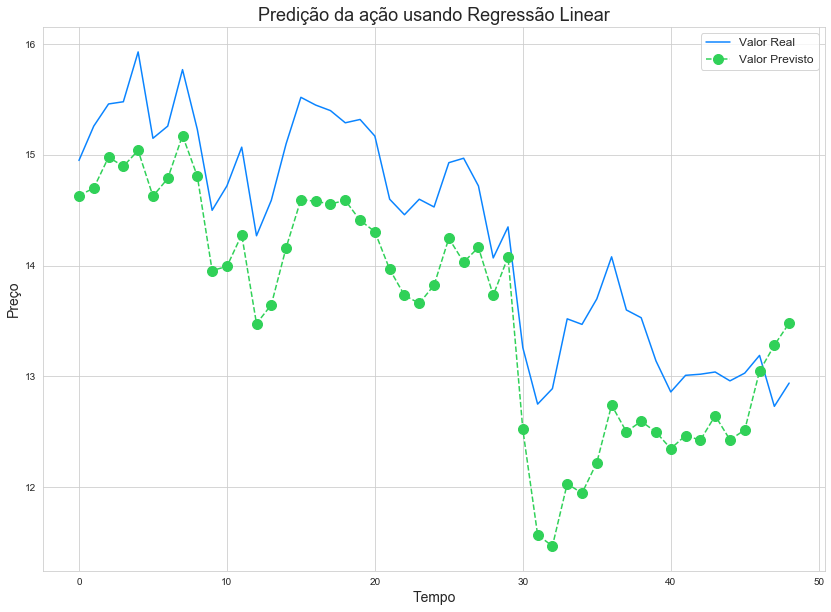

[0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1
 0 0 0 1 1 1 0 0 1 0]
[0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1
 0 0 0 1 1 1 0 0 1 0]


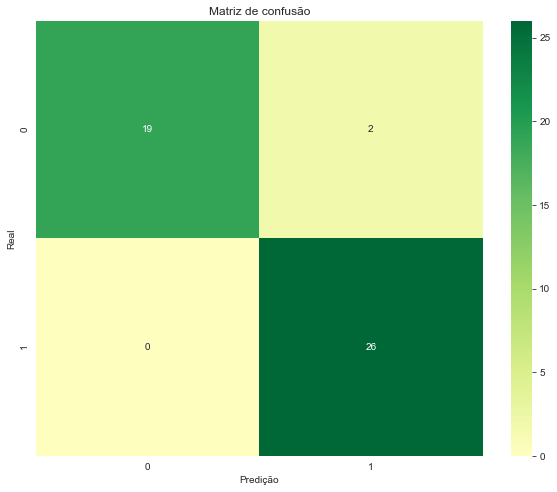

F1 score:  0.962962962962963
Precision score:  0.9285714285714286
Accuracy score:  0.9574468085106383
MAE score:  0.9118355714349136
MSE value:  0.9503331502197621
RMSE value:  0.974850321957049
MAPE value:  2.969669632620682


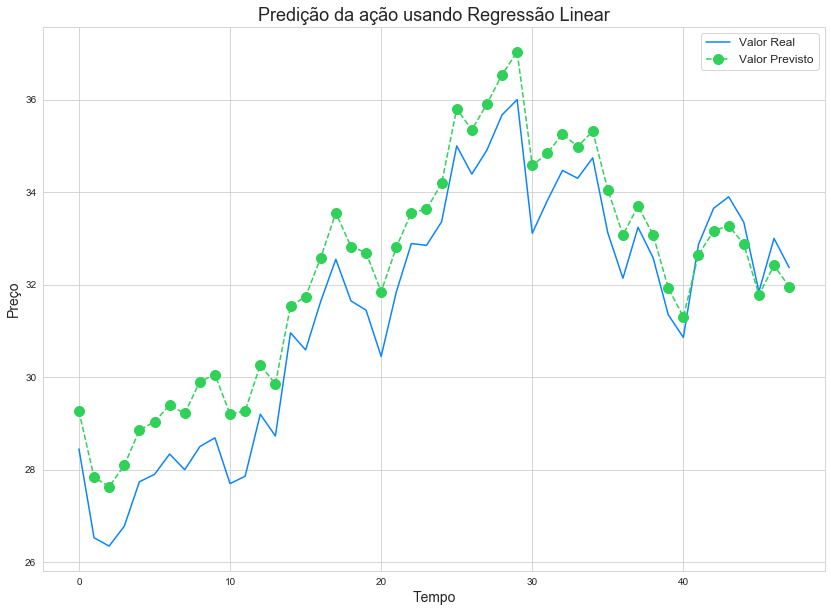

[1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1]


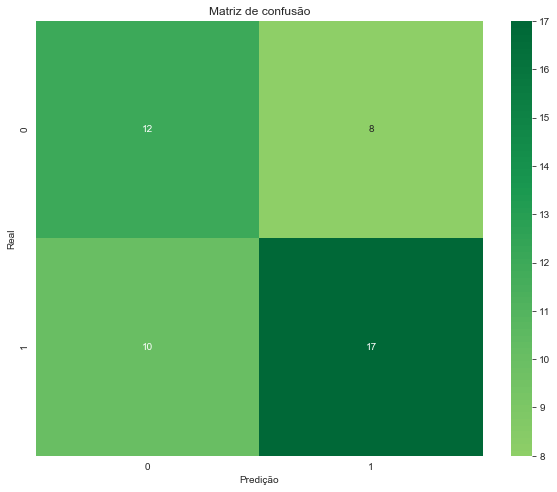

F1 score:  0.6538461538461539
Precision score:  0.68
Accuracy score:  0.6170212765957447
MAE score:  1.3034612849006735
MSE value:  2.1753757554888673
RMSE value:  1.474915507915239
MAPE value:  3.1154210149184633


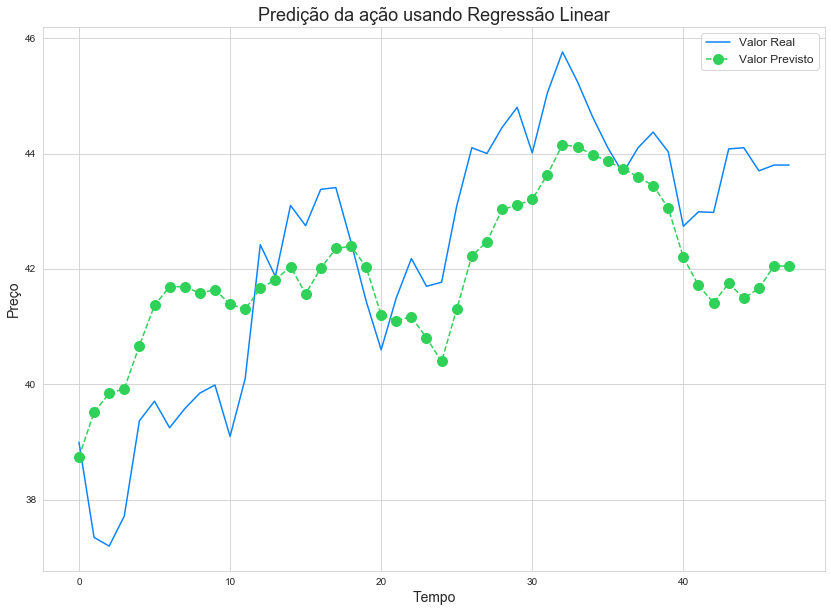

[1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0
 0 1 0 1 1 0 1 0 0 0 1]
[1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0]


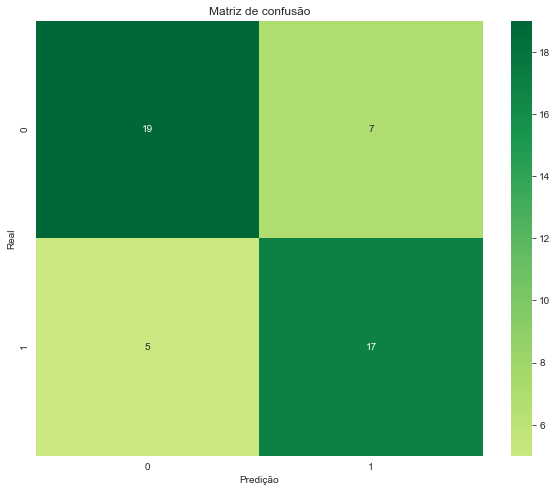

F1 score:  0.7391304347826088
Precision score:  0.7083333333333334
Accuracy score:  0.75
MAE score:  0.9799535740274214
MSE value:  2.528499292531557
RMSE value:  1.5901255587316232
MAPE value:  6.372887040025972


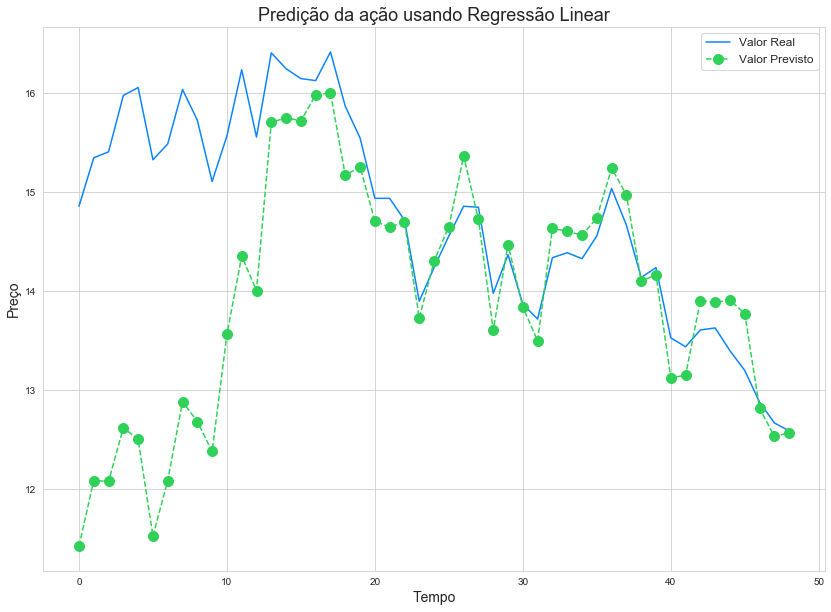

[1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 1 1 0 0 1 0 1]
[1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0
 1 0 0 1 1 1 0 0 1 0 1]


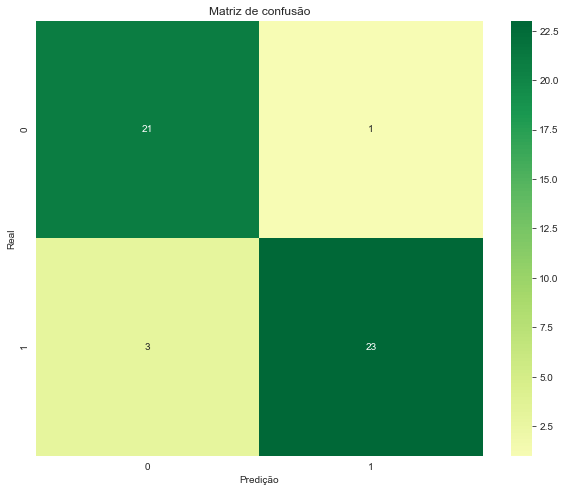

F1 score:  0.9199999999999999
Precision score:  0.9583333333333334
Accuracy score:  0.9166666666666666
MAE score:  0.04943061643110008
MSE value:  0.004283525908910964
RMSE value:  0.06544865093270422
MAPE value:  0.5557809374689664


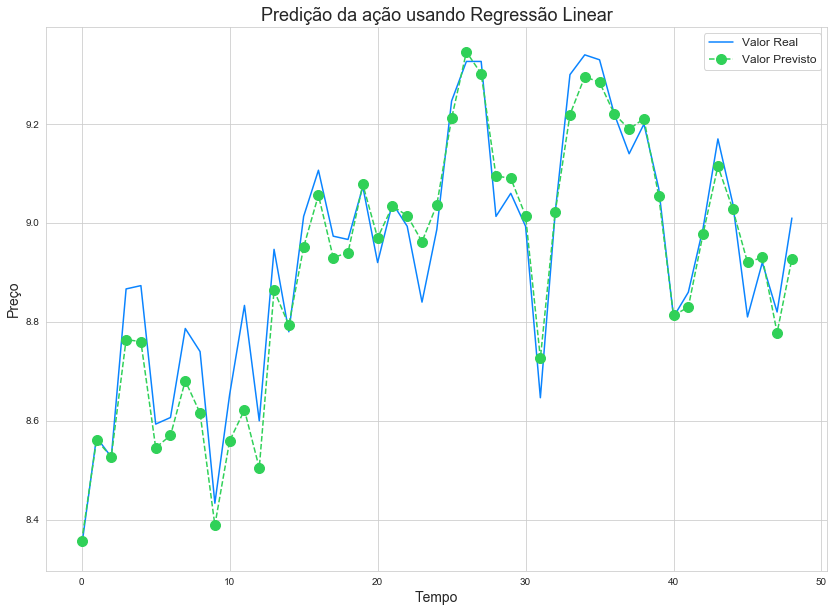

[0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0
 0 1 0 0 1 1 1 1 0 1]
[0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1
 0 1 0 0 1 1 1 1 0 1]


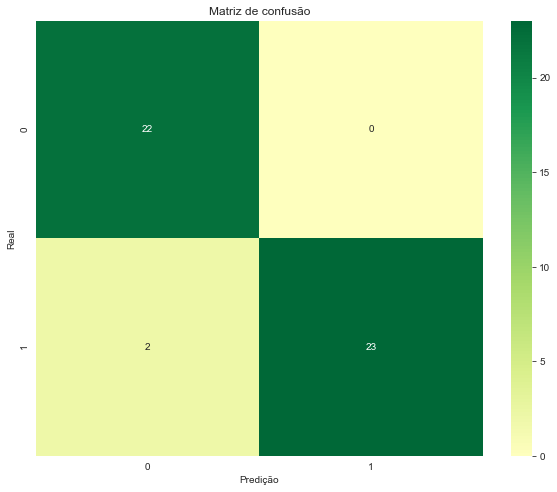

F1 score:  0.9583333333333334
Precision score:  1.0
Accuracy score:  0.9574468085106383
MAE score:  0.35631262601949937
MSE value:  0.19205515053726685
RMSE value:  0.4382409731383715
MAPE value:  3.4871425549967006


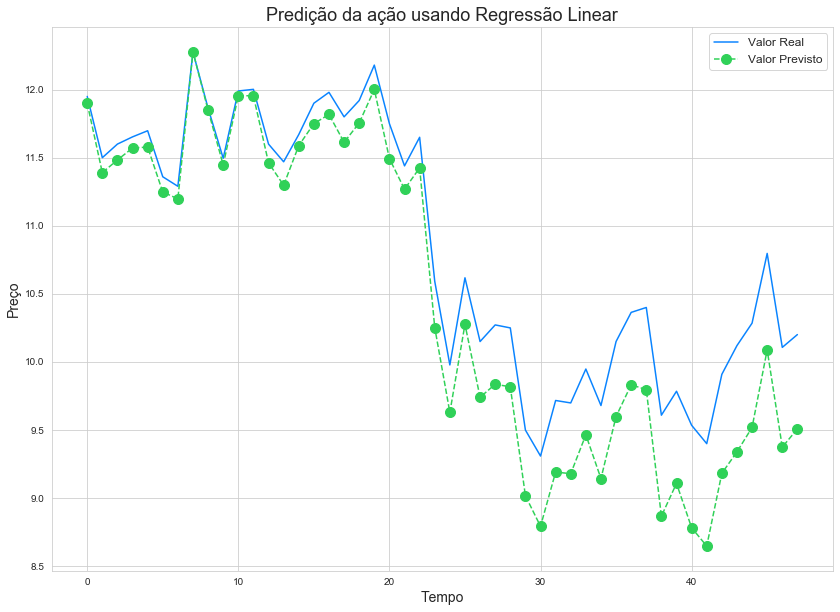

In [64]:
predict_linear_all_stocks(historicStock)

[1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0
 0 1 0 1 1 0 1 0 0 0 1]
[1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0]


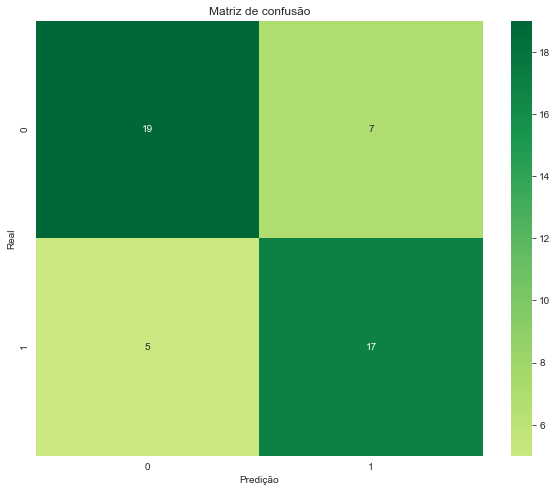

F1 score:  0.7391304347826088
Precision score:  0.7083333333333334
Accuracy score:  0.75
MAE score:  0.9799535740274214
MSE value:  2.528499292531557
RMSE value:  1.5901255587316232
MAPE value:  6.372887040025972


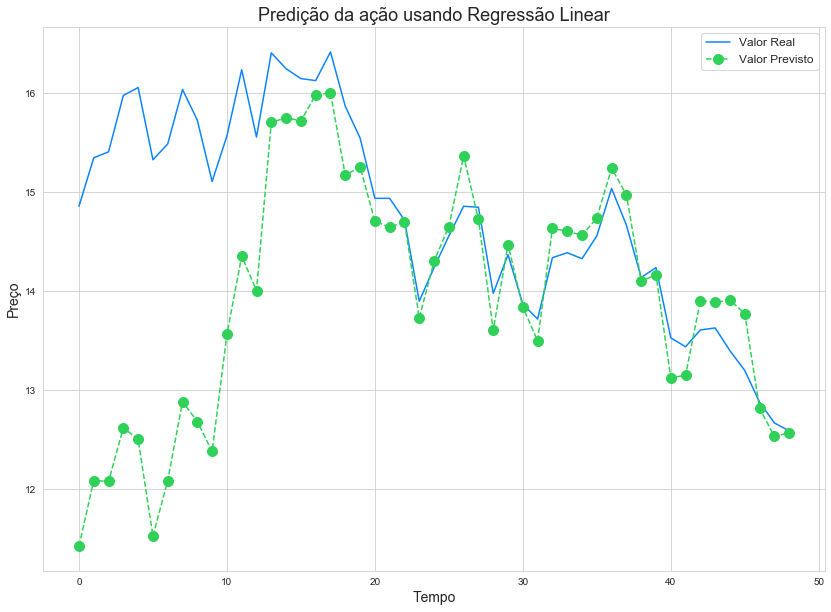

In [54]:
predict_linear(historicStock[3])